# Extended Data Fig. 7C
## Multi-round response overlap

For "Network-level encoding of local neurotransmitters in cortical astrocytes" (Cahill et al. 2024)

---

## Setup

#### Imports

In [1]:
# Typing

from numpy.typing import(
    ArrayLike,
)

# Others

from pathlib import Path
from itertools import combinations

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

from tqdm import tqdm

# Internal

from uncaging import (
    Helper,
)

import uncaging.utils as uutils
import uncaging.events as uevents
import uncaging.stats as ustats


#### Parameters

In [2]:
params_path = Path( 'config' ) / 'panels' / 'net_astro-s7c.yaml'
params = uutils.load_params( params_path )

#### Initial setup

In [3]:
helper = Helper(
    config_path = params['helper_configs'],
    hive_root = params['hive_root'],
    output_to = params['output_parent'],
)

# For reproducible results with randomness
np.random.seed( params['random_seed'] )

# Output saving
notebook_stem = params['notebook_stem']
analysis = params['analysis']

save_figure = helper.figure_saver( notebook_stem, analysis )
save_data = helper.data_saver( notebook_stem, analysis )
save_csv = helper.csv_saver( notebook_stem, analysis )

---

## Load data

In [4]:
events_analyze = helper.load_analysis_events(
    analysis,
    extra_decorators = [],
    verbose = True
)

Loading 20230720_CytoGp36f_S2_R3_RuBiGlu3_024_Ch0_moco_cell-events.mat...: 100%|██████████| 146/146 [00:08<00:00, 16.30it/s]             
Loading 20230720_CytoGp36f_S2_R3_RuBiGlu3_024_Ch0_moco_cell-events.mat...: 100%|██████████| 146/146 [00:08<00:00, 17.94it/s]             



Experiment GABA-repeat-70
    Excluded cells: 869
    Included cells: 371


Experiment Glu-repeat-70
    Excluded cells: 991
    Included cells: 343



In [5]:
events_analyze, events_prop, events_no_prop = uevents.split_events_prop(
    events_analyze,
    threshold = params['prop_threshold'],
)

---

## Analysis

#### TODO: These have duplication with 4M and S7C

### Helpers

In [6]:
def similarity_jaccard(
        x: ArrayLike,
        y: ArrayLike
    ) -> float:
    """
    TODO
    """
    return np.sum( (x == 1) & (y == 1) ) / np.sum( (x == 1) | (y == 1) )

def active_comparison_stats(
        results,
        n_perm: int = 10000
    ):
    """
    TODO
    """
    
    ret = dict()
    
    comparison_keys = [k for k in results.keys()
                       if 'ratio_active' in k]
    
    for comparison in list( combinations( comparison_keys, 2 ) ):
        
        cur_ret = dict()
        
        x = results[comparison[0]]
        y = results[comparison[1]]
        
        print( comparison )
        
        cur_ret['spearman'] = scipy.stats.spearmanr( x, y )
        cur_ret['spearman_p'] = cur_ret['spearman'].pvalue
        print( f'    Spearman: {scipy.stats.spearmanr( x, y )}' )
        
        spearman_perm = np.zeros( (n_perm,) )
        for i_perm in tqdm( range( n_perm ) ):
            x_perm = np.random.permutation( x )
            y_perm = np.random.permutation( y )
            spearman_perm[i_perm] = scipy.stats.spearmanr( x_perm, y_perm )[0]
        cur_ret['spearman_perm'] = spearman_perm
        cur_ret['spearman_p_perm'] = ustats.perm_p( np.sum( np.abs( spearman_perm ) >= np.abs( cur_ret['spearman'][0] ) ), n_perm )
        print( f'    Spearman p (perm): {cur_ret["spearman_p_perm"]}' )
        
        plt.figure( figsize = (4, 3) )
        plt.hist( spearman_perm, bins = np.arange( -0.55, 0.56, 0.1 ) )
        yl = plt.ylim()
        plt.plot( [cur_ret['spearman'][0], cur_ret['spearman'][0]], yl, 'k-', linewidth = 2 )
        plt.show()
        
        #
        
        jaccard = similarity_jaccard( x, y )
        cur_ret['jaccard'] = jaccard
        
        jaccard_perm = np.zeros( (n_perm,) )
        for i_perm in tqdm( range( n_perm ) ):
            x_perm = np.random.permutation( x )
            y_perm = np.random.permutation( y )
            jaccard_perm[i_perm] = similarity_jaccard( x_perm, y_perm )
        cur_ret['jaccard_perm'] = jaccard_perm
        cur_ret['jaccard_p_perm'] = ustats.perm_p( np.sum( jaccard_perm >= jaccard ), n_perm )
        print( f'    Jaccard: {jaccard}' )
        print( f'    Jaccard p (perm): {cur_ret["jaccard_p_perm"]}' )
        
        plt.figure( figsize = (4, 3) )
        plt.hist( jaccard_perm, bins = 10 )
        yl = plt.ylim()
        plt.plot( [jaccard, jaccard], yl, 'k-', linewidth = 2 )
        plt.show()
        
        ret[comparison] = cur_ret
    
    return ret

### Setup

In [7]:
# These are keys we might need for downstream coregistration
params['responders']['keep_keys'] = [
    'dataset_id',
    'dataset_id_all',
    'condition',
    'mouse',
    'fov',
    'repeat',
    'fov_coreg',
    'slice_all',
    'cell_global_all',
    'cell_global_coreg',
]

# Save some duplication in the `responders` params
params['responder_fractions'].update( params['responders'] )

responder_cache_keys = [
    'mouse',
    'slice_all',
    'dataset_id_all',
    'cell_global_coreg',
    'ratio_active',
]

***

### Result: Neighbor cells, pattern overlap

In [8]:
condition_key = params['condition_key']
condition = params['condition']

if params['event_type'].lower().startswith( 'prop' ):
    events_subset = events_prop.copy()
elif params['event_type'].lower().startswith( 'static' ):
    events_subset = events_no_prop.copy()
elif params['event_type'].lower().startswith( 'all' ):
    events_subset = events_analyze.copy()
else:
    raise ValueError( f'Unrecognized event type: {params["event_type"]}' )

filter_events_condition = (events_subset[condition_key] == condition)
filter_events_neighbor = events_subset['is_uncage'] == False
filter_events_panel = filter_events_condition & filter_events_neighbor

events_panel = events_subset.copy()[filter_events_panel]

Mice:            n = 5
Slices per NT:   n = 8
Datasets per NT: n = 15
Cells:           n = 32
('ratio_active_1', 'ratio_active_2')
    Spearman: SignificanceResult(statistic=-0.040128617695256406, pvalue=0.8273839994961122)


100%|██████████| 10000/10000 [00:02<00:00, 4461.78it/s]


    Spearman p (perm): 1.0


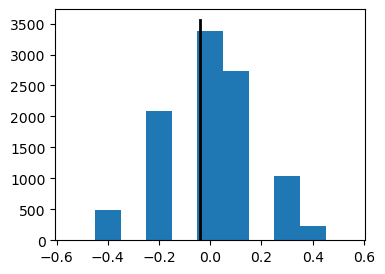

100%|██████████| 10000/10000 [00:00<00:00, 30890.69it/s]

    Jaccard: 0.13333333333333333
    Jaccard p (perm): 0.7423257674232576


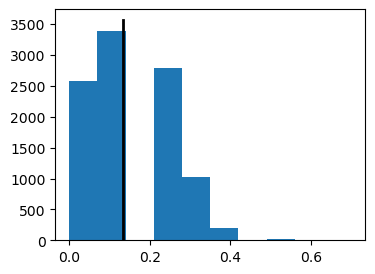

Mice:            n = 5
Slices per NT:   n = 7
Datasets per NT: n = 16
Cells:           n = 30
('ratio_active_1', 'ratio_active_3')
    Spearman: SignificanceResult(statistic=0.13875598086124405, pvalue=0.46462462293241136)


100%|██████████| 10000/10000 [00:02<00:00, 4401.75it/s]

    Spearman p (perm): 0.6957304269573042


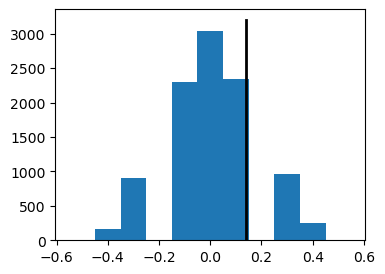

100%|██████████| 10000/10000 [00:00<00:00, 31759.63it/s]

    Jaccard: 0.29411764705882354
    Jaccard p (perm): 0.34496550344965504


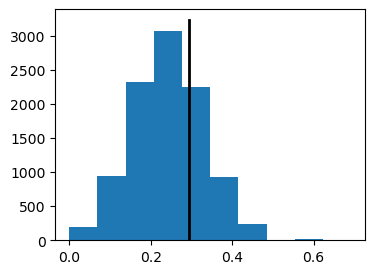

Mice:            n = 5
Slices per NT:   n = 8
Datasets per NT: n = 17
Cells:           n = 38
('ratio_active_2', 'ratio_active_3')
    Spearman: SignificanceResult(statistic=0.05913123959890826, pvalue=0.724357013192179)


100%|██████████| 10000/10000 [00:02<00:00, 4498.78it/s]


    Spearman p (perm): 0.7354264573542646


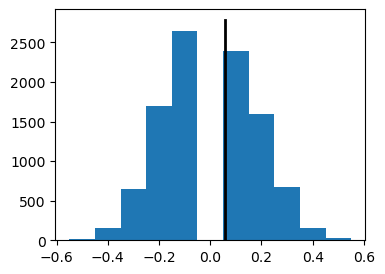

100%|██████████| 10000/10000 [00:00<00:00, 30396.88it/s]


    Jaccard: 0.2608695652173913
    Jaccard p (perm): 0.49735026497350265


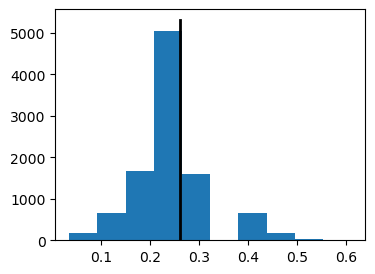

In [9]:
results_active_comparison_overall = dict()

for repeat_pair in params['repeats_compare']:

    # Normalization
    repeat_pair = tuple( repeat_pair )

    responders_per_condition = []

    for repeat in repeat_pair:

        filter_events_repeat = (events_panel['repeat'] == repeat)
        events_cur = events_panel[filter_events_repeat]

        responders_cur = uevents.responders(
            events_cur,
            params['coreg_key'],
            **params['responders']
        )
        responders_per_condition.append( responders_cur[responder_cache_keys] )

    responders_overall = pd.merge(
        responders_per_condition[0], responders_per_condition[1],
        on = params['coreg_key'],
        how = 'inner',
        suffixes = [f'_{x}' for x in repeat_pair],
    )
    
    print( f"Mice:            n = {len( responders_overall[f'mouse_{repeat_pair[0]}'].unique() )}" )
    print( f"Slices per NT:   n = {len( responders_overall[f'slice_all_{repeat_pair[0]}'].unique() )}" )
    print( f"Datasets per NT: n = {len( responders_overall[f'dataset_id_all_{repeat_pair[0]}'].unique() )}" )
    print( f"Cells:           n = {len( responders_overall['cell_global_coreg'].unique() )}" )
    
    results_active_comparison = active_comparison_stats( responders_overall )
    results_active_comparison_overall[repeat_pair] = results_active_comparison

In [10]:
spearman_disp = np.zeros( (3, 3) )
spearman_disp[:, :] = np.nan

for repeats_compare, results_active_comparison in results_active_comparison_overall.items():
    cur_key = (f'ratio_active_{repeats_compare[0]}', f'ratio_active_{repeats_compare[1]}')
    cur_spearman = results_active_comparison[cur_key]['spearman'].statistic
    spearman_disp[repeats_compare[0] - 1, repeats_compare[1] - 1] = cur_spearman

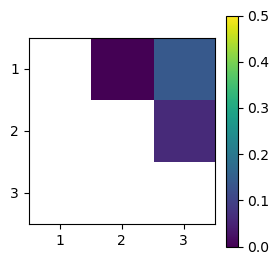

In [11]:
plt.figure( figsize = (3, 3))
plt.imshow( spearman_disp,
            clim = (0, 0.5) )
plt.colorbar()

plt.yticks( [0, 1, 2], [1, 2, 3] )
plt.xticks( [0, 1, 2], [1, 2, 3] )

save_figure( f'{condition}-rounds-spearman' )

plt.show()